Import Dependencies
-

In [678]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from deepctr.models import DeepFM
from deepctr.feature_column import SparseFeat, DenseFeat,get_feature_names

from sklearn.metrics import log_loss, roc_auc_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib

import time
import sys

import tensorflow as tf
from tensorflow.python.keras.models import  save_model,load_model
from tensorflow.keras import layers
from deepctr.layers import custom_objects

import numpy as np
import math
from collections import deque
import random
import heapq

Define Synthetic Model
-

In [653]:
#Synthetic model to be used as an objective ground truth measure of explainability, using feature instability as a proxy  
def query_synth_model(node):
    point = node.position
    if (1/9*point[0]**4) + (point[1]**4) < 3:
        return 1
    else:
        return 0
        
source_node = Node(np.asarray([0,0]), 0) #Position, Distance to source_node
query_synth_model(source_node)

1

Generate Training Data
-

(1000, 2)

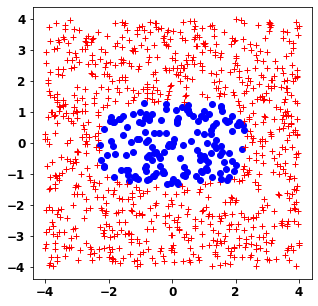

In [654]:
#Create "training data" to use for calculating feat_ranges to infer search step sizes
fig, ax = plt.subplots(figsize = (5, 5))
#plt.ylim(-2,2)
#plt.xlim(-2,2)

nfeats = 2
dense_features = np.arange(nfeats)
data = []
labels = []
nsamp = 1000
for _ in range(nsamp):
    point = np.random.uniform(low=-4, high=4, size=(nfeats,))
    node = Node(point, None)
    rec = query_synth_model(node)
    data.append(point)
    labels.append(rec)
    
    if rec == 1:
        plt.plot(point[0],point[1],'bo')
    else:
        plt.plot(point[0],point[1],'r+')

data = pd.DataFrame(data)
data.shape

In [656]:
def get_num_range(data, dense_features):
    #Returns (range) of values for each I1-I13 integer features
    num_data_distrib = []
    for feat in dense_features:
        feature = data[feat]
        #num_data_distrib.append([feature.min(), feature.max(), np.std(feature), feature.mean()])
        #num_data_distrib.append([feature.min(), feature.max(), feature.max() - feature.min()])
        #num_data_distrib.append([feature.max() - feature.min()])
        num_data_distrib.append([3 * np.std(feature)]) #Range contains 99.7% of samples in training data
    
    return np.asarray(num_data_distrib)
    
feat_ranges = get_num_range(data, dense_features)
print(feat_ranges.shape)
feat_ranges

(2, 1)


array([[7.04577361],
       [6.92088375]])

In [235]:
class Node:
    def __init__(self, position, distance):
        
        #Position list([row, column])
        self.position = position # [n1, n2, ..., n|N|]
        self.distance = distance #Distance for evaluation function to compare nodes in priority queue
        
  # Nodes with the same distance
    def __eq__(self, other):
        return isinstance(other, Node) and self.distance == other.distance
  
    # Node is less than other node
    def __lt__(self, other):
        return isinstance(other, Node) and self.distance < other.distance

    # Node is greater than other node
    def __gt__(self, other):
        return isinstance(other, Node) and self.distance > other.distance

In [972]:
def get_distance(source_node, query_node, feat_scaler, distance='Manhattan'):
    #returns distance for ndim feature space
    
    dif = query_node.position - source_node.position
    scaled_dif = (dif / feat_scaler)[0]
    
    # More efficient at scale
    if distance == 'Manhattan':
        return sum(abs(scaled_dif))
    
    if distance == 'Euclidean':
        dsum = 0
        for feat in dif:
            dsum += feat**2
        return math.sqrt(dsum)

    
def generate_unit_vectors(nfeats,nvectors=1):

    #np.random.seed(3)
    vectors = []
    for _ in range(nvectors):
        v = np.random.uniform(low=-1, high=1, size=(nfeats,))
        v_hat = v / np.linalg.norm(v)
        vectors.append(v_hat)
    return vectors


def generate_precursor_solutions(source_node, feat_ranges, k=20, nsteps=6, plot_search=False):

    step_sizes = (feat_ranges/nsteps) #How large of a step to take for each respective int feature
    feat_scaler = 1/np.asarray(feat_ranges) #Scale to normalize feature step size when calculating distance
    
    #Normalized step size for searching every feature
    feat_steps = []
    for feat in range(len(feat_ranges)):
        feat_steps.append(np.arange(step_sizes[feat],feat_ranges[feat],step_sizes[feat]))
    feat_steps = np.asarray(feat_steps)
    
    source_rec = query_synth_model(source_node)
    
    if plot_search:
        plt.plot(source_node.position[0],source_node.position[1],'r+')

    discovered = []

    while len(discovered) < k:
        unit_vector = generate_unit_vectors(len(source_node.position))[0]
        for step in range(nsteps-1):
            scaled_vector_position = np.asarray(unit_vector * feat_steps.T[step] + source_node.position)
            scaled_vector = Node(scaled_vector_position, None)
            query_rec = query_synth_model(scaled_vector)
            
            if plot_search:
                if query_rec == source_rec:
                    color = 'bo'
                else:
                    color = 'y^'
                plt.plot(scaled_vector.position[0],scaled_vector.position[1],color)
            
            if source_rec != query_rec:
                # distance heuristic
                scaled_vector.distance = get_distance(source_node, scaled_vector, feat_scaler)
                discovered.append(scaled_vector)
                break
    
    return discovered

In [840]:
#TODO: Adapative gradient to make largest jumps in k-closest solutions in beginning, then lower over time

def find_adjs(node, feat_scaler, learning_rate):
    #Returns all nodes adjacent to current solution in ndim feature space
    
    adj_nodes = []
    pos = node.position
    for dim in range(len(pos)):
        #Check if dim is a missing value, as marked in cat_dims_to_emb()
        if pos[dim] != None:
            temp = pos.copy().astype(float)
            temp[dim] += learning_rate / feat_scaler[dim]
            adj_nodes.append(Node(temp, None))
            temp = pos.copy().astype(float)
            temp[dim] -= learning_rate / feat_scaler[dim]
            adj_nodes.append(Node(temp, None))
    return adj_nodes


# If the query_node is too close to an existing solution, it is omitted to encourage discovery of new
# territory along the decision boundary
def neighboring_solution(discovered, query_node, neighborhood_size, feat_scaler):

    for solution in discovered:
        distance = get_distance(solution, query_node, feat_scaler)
        if distance < neighborhood_size:
            return True
    
    return False


#A* without clustering constraint
def a_star_search(source_node, prelim_discovered, feat_ranges, k=100, learning_rate=0.25):
    
    #Analytics to inform how to handle degree of branching
    nodes_generated = 0
    nodes_visited = 0
    
    frontier = [] # Priority Queue
    discovered = [] #Vector of k-closest feature interactions to opposite recommendation
    visited = {} # True corresponds to visited for low complexity "visited" search
    
    #Add solutions from uniformly distributed vectors to priority queue (frontier)
    for soln_node in prelim_discovered:
        heapq.heappush(frontier, soln_node)
        nodes_generated += 1
        
    #Scale to normalize learning rate for each feature
    feat_scaler = 1/np.asarray(feat_ranges)
    
    source_rec = query_synth_model(source_node) #rec value to be explained
     
    # loop till queue is empty, or k solutions were discovered
    #TODO: Want to define stop criteria based on no solutions approaching center
    while frontier and len(discovered) < k:
 
        # dequeue front node
        query_node = heapq.heappop(frontier)
        #print(node, end=' ')
        nodes_visited += 1
        
        #Check goal state
        query_rec = query_synth_model(query_node)
        if query_rec != source_rec:
            #Do not use solution if previous discovered is in close neigborhood
            if not neighboring_solution(discovered, query_node, learning_rate, feat_scaler):
                discovered.append(query_node)
                visited[tuple(query_node.position)] = True
                #print("soln:",query_node.position)
                print(len(discovered),end=' ')
                
 
        #Add adjacents to priority queue before visiting them
        adjs = find_adjs(query_node, feat_ranges, learning_rate) #every node adjacent to the current node
        for adj_node in adjs:
            
            in_bfet = True
            for i in range(len(adj_node.position)):
                if adj_node.position[i] >= feat_ranges[i] or adj_node.position[i] <= -1*feat_ranges[i]:
                    in_bfet = False
            
            if in_bfet and tuple(adj_node.position) not in visited.keys():
                
                adj_node.distance = get_distance(source_node, adj_node, feat_scaler)
                heapq.heappush(frontier, adj_node)
                visited[tuple(adj_node.position)] = True
                nodes_generated += 1
    
    print("Nodes Visited:",nodes_visited)
    print("Nodes Generated:",nodes_generated)
    print("Visited Length:",len(visited))

    return discovered

----

In [971]:
# Puts solution node into a n-way feature interaction cluster
def cluster_feat_int(node, solution_clusters, feat_scaler, max_cluster_size):
    
    scaled_feats = node.position * feat_scaler[0] #Scales features to same scale of distance
    f_max = np.argmax(abs(scaled_feats)) #Most dominant feature in solution
    f_ratios = np.zeros(len(feat_ranges)) #Marks which feature interaction was expressed by the node position
    
    #Loop through each feature of a single solution, and determine degree of multi-feature interaction
    for f_i in range(len(scaled_feats)):
        
        if abs(scaled_feats[f_max]/scaled_feats[f_i]) <= 2:
            if scaled_feats[f_i] > 0:
                f_ratios[f_i] = 1
            else:
                f_ratios[f_i] = -1
                        
    if tuple(f_ratios) not in solution_clusters:
        solution_clusters[tuple(f_ratios)] = []
    #Add solution to cluster if f_ratios isn't overrepresented in solution_clusters
    full_cluster = False
    if len(solution_clusters[tuple(f_ratios)]) < max_cluster_size:
        solution_clusters[tuple(f_ratios)].append(node.position)
        #print('  CFI',node.position)
        
    else:
        full_cluster = True
    
    return solution_clusters, full_cluster

In [970]:
def sort_solution_clusters(solution_clusters,source_node,feat_scaler):
    
    all_distances = []
    for key in solution_clusters:
        total_distance = []
        for soln in solution_clusters[key]:
            distance = get_distance(source_node, Node(soln,None), feat_scaler)
            total_distance.append(distance)
        all_distances.append(np.sort(total_distance))
        #print(key,':',(solution_clusters[key] * np.asarray(key)).mean())
        
    sorted_clusters = []
    i = 0
    for key in solution_clusters:
        min_sample = all_distances[i].min()
        sorted_clusters.append((min_sample,key))
        i+=1
    np.asarray(sorted_clusters).sort(axis=0)
    
    return sorted_clusters

In [969]:
def display_instability(sorted_clusters):
    x = [str(feat_interaction[1]) for feat_interaction in sorted_clusters]
    energy = [1/feat_interaction[0] for feat_interaction in sorted_clusters]
    variance = [0 for _ in x]

    x_pos = [i for i, _ in enumerate(x)]

    plt.bar(x_pos, energy, color='blue', yerr=variance)
    plt.xlabel("Feature Interaction")
    plt.ylabel("Feature Instability \n(1/Distance from Source to Alternate Rec)")
    plt.title("Instability of Feature Interactions \n in Recommending <Source Node>")

    plt.xticks(x_pos, x)

    font = {'weight' : 'bold',
            'size'   : 12}

    #matplotlib.rc('font', **font)

    #plt.rcParams["figure.figsize"] = (5,5)
    #plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
    plt.show()

In [973]:
#A* with solution cluster tracking
# k = number of total opposite rec solutions
def a_star_search(source_node, prelim_discovered, feat_ranges, k=100, learning_rate=1, max_cluster_size=100):
    
    #Analytics to inform how to handle degree of branching
    nodes_generated = 0
    nodes_visited = 0
    
    frontier = [] # Priority Queue
    discovered = [] #Vector of k-closest feature interactions to opposite recommendation... redundant with solution_clusters{} now
    visited = {} # True corresponds to visited for low complexity "visited" search
    solution_clusters = {} #Feature-interaction clusters of shortest path solutions
    
    #Add solutions from uniformly distributed vectors to priority queue (frontier)
    for soln_node in prelim_discovered:
        heapq.heappush(frontier, soln_node)
        nodes_generated += 1
        
    #Scale to normalize learning rate for each feature
    feat_scaler = 1/np.asarray(feat_ranges)
    
    source_rec = query_synth_model(source_node) #rec value to be explained
     
    # loop till queue is empty, or k solutions were discovered
    #TODO: Want to define stop criteria based on no solutions approaching center
    while frontier and len(discovered) < k:
 
        # dequeue front node to determine if its a solution, and find its adjacents
        query_node = heapq.heappop(frontier)
        #print(node, end=' ')
        nodes_visited += 1
        
        #Check goal state, and adds to solutions cluster if so
        full_cluster = False #Flag indicating if this feature-interaction should continue being searched
        query_rec = query_synth_model(query_node)
        if query_rec != source_rec:
            #Do not use solution if previous discovered is in close neigborhood
            if not neighboring_solution(discovered, query_node, learning_rate, feat_scaler):
                visited[tuple(query_node.position)] = True
                #print("soln:",query_node.position)
                #Add node to soln cluster if not already full
                solution_clusters, full_cluster = cluster_feat_int(query_node, solution_clusters, feat_scaler, max_cluster_size)
                if not full_cluster:
                    discovered.append(query_node)
                    print(len(discovered),end=' ')
 
        #Add adjacents to priority queue before visiting them
        adjs = find_adjs(query_node, feat_ranges, learning_rate) #every node adjacent to the current node
        for adj_node in adjs:
            
            #Checks if generated adjacent node position is within reasonable values
            in_bfet = True
            for i in range(len(adj_node.position)):
                if adj_node.position[i] >= feat_ranges[i] or adj_node.position[i] <= -1*feat_ranges[i]:
                    in_bfet = False
            
            #Add adj_node to priority queue to be checked later, with its given distance to the source
            if in_bfet and not full_cluster and tuple(adj_node.position) not in visited.keys():
                adj_node.distance = get_distance(source_node, adj_node, feat_scaler)
                heapq.heappush(frontier, adj_node)
                visited[tuple(adj_node.position)] = True
                nodes_generated += 1
    
    print("Nodes Visited:",nodes_visited)
    print("Nodes Generated:",nodes_generated)
    print("Visited Length:",len(visited))

    return discovered, solution_clusters

In [975]:
source_node = Node(np.asarray([0,-1]), 0) #Position, Distance to source_node
feat_ranges = get_num_range(data, dense_features)
feat_scaler = 1/np.asarray(feat_ranges)

prelim_discovered = generate_precursor_solutions(source_node, feat_ranges, plot_search=False, nsteps=10, k=25)
mid_discovered,solution_clusters = a_star_search(source_node, discovered, feat_ranges, learning_rate=10, k=50)
refined_discovered,solution_clusters = a_star_search(source_node, mid_discovered, feat_ranges, k=50, learning_rate=0.5, max_cluster_size=5)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 Nodes Visited: 24670
Nodes Generated: 33703
Visited Length: 33508
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 Nodes Visited: 11583
Nodes Generated: 11583
Visited Length: 11583


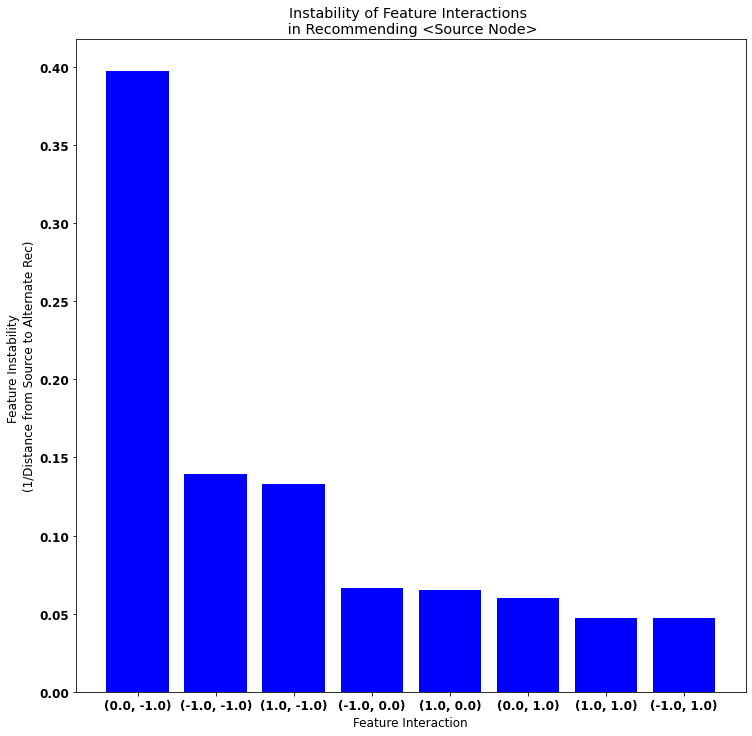

In [982]:
#plt.rcParams["figure.figsize"] = (12,12)
sorted_clusters = sort_solution_clusters(solution_clusters,source_node,feat_scaler)
display_instability(sorted_clusters)

Dark Blue: Initial Search
Light Blue: A* High Learning Rate Search
Red: A* Low Refined Learning Rate Search


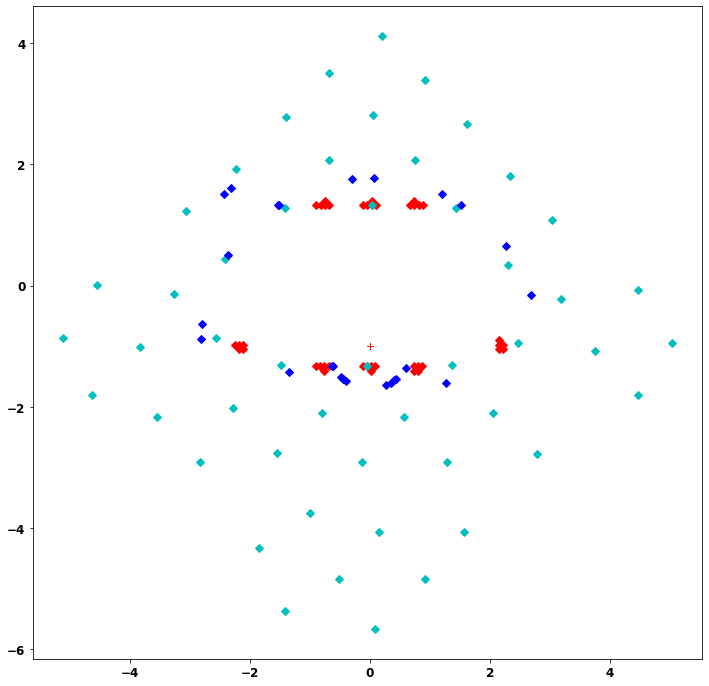

In [974]:
#Display solutions of GD-FETS using discovered list
def plot_solutions(source_node, discovered,color_index=0):
    colors = ['bD','gD','rD','cD','kD','mD','yD','b*','g+']
    plt.plot(source_node.position[0],source_node.position[1],'r+')
    for point in discovered:
        plt.plot(point.position[0],point.position[1],colors[color_index])

plot_solutions(source_node, refined_discovered,color_index=2)      
plot_solutions(source_node, mid_discovered,color_index=3)
plot_solutions(source_node, prelim_discovered,color_index=0)
print("Dark Blue: Initial Search")
print("Light Blue: A* High Learning Rate Search")
print("Red: A* Low Refined Learning Rate Search")

(0.0, -1.0) : bD
(-1.0, -1.0) : gD
(1.0, -1.0) : rD
(-1.0, 0.0) : cD
(1.0, 0.0) : kD
(0.0, 1.0) : mD
(1.0, 1.0) : yD
(-1.0, 1.0) : b*


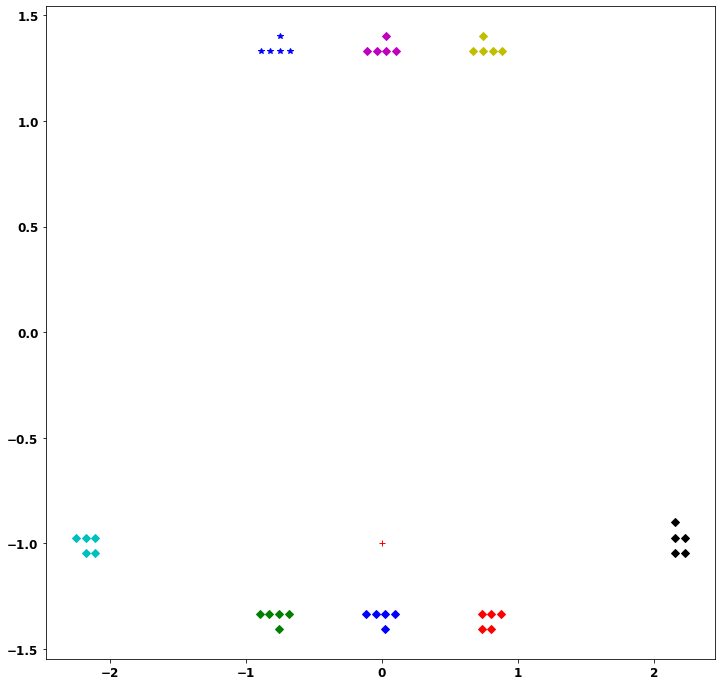

In [967]:
#Display solutions of GD-FETS using solution_clusters
plt.plot(source_node.position[0],source_node.position[1],'r+')
i=0
for cluster in solution_clusters:
    print(cluster,':',colors[i])
    for point in solution_clusters[cluster]:
        plt.plot(point[0],point[1],colors[i])
    i+=1

TODO:
-
- Generate Ground Truth (GT) evaluation model with manufactured decision boundary surrounding source node, to provide a GT of explainability as defined by the function that creates the search space. This function will be used to compare the accuracy of GD-FETS to LIME. It should build the decision boundary given input parameters of which feature interactions should have what degree of instability.
- Implement LIME/SHAP to give comparison of their performance using a Ground Truth decision boundary, to that of GD-FETS
- Implement one-way feature-interaction for GD-FETS for direct comparison to LIME
- T-tests to demonstrate signifiance of GD-FETS identifying the same feature interactions as expreesed in the GT explanation --> Only shortest distance is logical, as the average would be impacted by search bias artefacts... can show this once solutions hug the decision boundary in each solution cluster

----
- Adjust abstract to provide brief intro on importance of deep recsys/DNN explainability, followed by a majority of key features of GD-FETS
- Describe evaluation methodology in manuscript, and describe results
- Would like to do: Use T-SNE to project categorical embedding vectors from 4 dimension to 2 (reduce complexity of search space), can also collapse the dimensionality to a single dimension, although => information loss
- Use generators to dynamically create one-hot encoding labels for training embedding inversion models, for features with very large dictionary sizes, due to memory constraints
- Future Direction: Implement reinforcement learning agent to repalce the A* search engine, as RL policy can learn the most common explanability for a given model and feature values, which can be leveraged fro search.

Prev:
-
- Set limit of q solutions found per multi-way feature interaction, after finding k solutions with high learning rate
- find_adjs() to take certain step size based on learning rate
- Reject the generation of an adjacent node if it is too close to an existing solution, such that local maxima aren't overrepresented, giving a chance to find global maxima for a given feature-interaction cluster
- Implement solutions clustering method for identifying which multi-way feature interaction a sample is expressing
- Implement method to display the magnitude of instability for top-k feature interactions
- Use 2-3 Std devs of each feature of training data as feat_range for data distribution to ignore outliers that would cause certain features to be traversed with too large a step size

Rejected Ideas
-
- Set limit of k solutions found per multi-way feature interaction, such that after k solutions in a single feature-interaction cluster are found, every node in the priority queue that is a member of that cluster is removed, so that only other feature-interaction clusters are searched. =>  > k*(top_n_feat_ints_desired) must be identified --> How else to prevent the overwelming redundance of the single closest feature interaction in explaining a recommendation/prediction? --> Answer: larger learning rate s.t. more areas are covered, but this leads to less specificity near decision boundary of optimal positions
- Modify find_adjs() to only generate adjacents in direction of source node, to reduce memory complexity of frontier priority queue